## Axion Simulation

## Imports and Definitions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot as root

from multiprocessing import Pool
from scipy.interpolate import interp1d
from scipy.constants import physical_constants
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
from helperFunctions import *

In [2]:
# plot settings, increase font sizes
plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['legend.labelspacing'] = 0.2

## Experimental Parameters

In [3]:
# Parameters from ILL PF1b 2020 beamtime
ill2020 = {'l_sf'  :  0.4,   # length of the spin-flip coils in [m] 
           'l_int' :  4.2,   # length of the interaction zone in [m]
           'l_ele' :  3.0,   # length of the electrodes in [m]
           'l_tof' : 10.5,   # distance chopper -> detector in [m] 
           'l_det' :  2.148, # distance from SF2 -> detector in [m]
          }

# Example parameters for possible PSI BOA meausrement
boa2024 = {'l_sf'  :  0.2,   # length of the spin-flip coils in [m] 
           'l_int' :  1.5,   # length of the interaction zone in [m]
           'l_ele' :  1.0,   # length of the electrodes in [m]
           'l_tof' : 10.5,   # distance chopper -> detector in [m] 
           'l_det' :  1.5,   # distance from SF2 -> detector in [m]
          }

setup = dotdict(ill2020)

## Neutron Spectrum

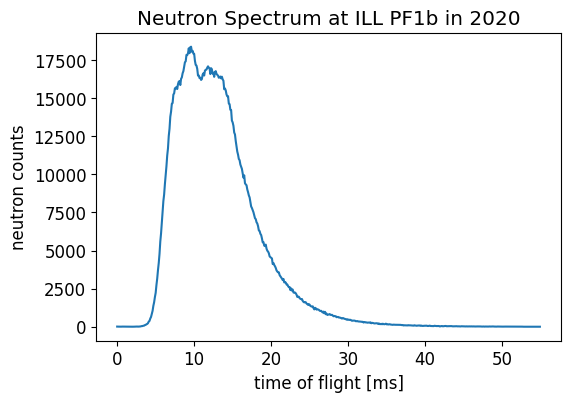

In [4]:
# detector settings
tBin = 10e-6
nBin = 5500

# time array of the tof
tof = np.arange(nBin)*tBin

# get data from ROOT file
file = 'data/neutronSpectrum_ILL_PF1b_2020_run045779.root'
with root.open('{}'.format(file)) as f:
    neutronCounts = np.asarray(f['myRunTree;1']['AllCount'].array()[0][:nBin])
    
# create a 1D function to weights the neutron counts
neutronCounts_Fct = interp1d(tof, neutronCounts, kind='cubic')

# plot the neutron spectrum
fig, ax = plt.subplots()
ax.plot(1e3*tof[::10], neutronCounts_Fct(tof[::10]))
ax.set(title='Neutron Spectrum at ILL PF1b in 2020', xlabel='time of flight [ms]', ylabel='neutron counts')
plt.show()

## Ramsey Frequency Scan

In [5]:
def ramseyFrequencyScan(omega_SF):

    # number of spin-flip signal phases to average over
    nPhase = 10
    
    # randomize the phase of the B1 field
    result = 0
    for theta in np.linspace(0, pi, nPhase, endpoint=False):
        result += abs(spinDn.T 
                      @ matSpinflip(tau+T, tau+T+tau, B0, B1, omega_SF, theta=theta, N=nSF) 
                      @ matPrecession(tau, tau+T, B0, N=1) 
                      @ matSpinflip(0, tau, B0, B1, omega_SF, theta=theta, N=nSF) 
                      @ spinUp)**2
    result /= nPhase
            
    return result

### Monochromatic Beam

In [6]:
filename = 'data/ramseyFrequencyScan_monochromaticBeam.npz'

# neutron velocity in [m/s]
v_n = 800

# neutron wavelength [m]
lambda_n = h / mass_n / v_n

# SF crossing time in [s]
tau = setup.l_sf / v_n
# free precession time in [s]
T = setup.l_int / v_n

# main magnetic field amplitude in [T]
B0 = 220e-6

# SF field amplitude in [T]
# optimial value for pi/2 flip
B1 = pi/2 / gamma_n / tau

# angular frequency of the spinflipper in [rad/s]
omega_SF = gamma_n * B0

# number of steps per oscillation in B1 field / axionic field
Q = 100

# number of steps for the full propagation
nSF = int(Q * tau * omega_SF / 2 / pi)

# print some parameters
print('expected resonance frequency:\t{:.0f} kHz'.format(abs(-gamma_n*B0)/2/pi))
print('expected resonance width:\t{:.0f} kHz'.format(v_n/setup.l_sf/2))
print('expected number of wiggles:\t{:.0f}'.format(T / tau))

expected resonance frequency:	6416 kHz
expected resonance width:	1000 kHz
expected number of wiggles:	10


In [7]:
try:
    Omega_SF = np.load(filename)['Omega_SF']
    pFlip = np.load(filename)['pFlip']

except:
    Omega_SF = np.arange(4400, 8600+1, 10) * 2*pi

    with Pool(processes=6) as pool:
        pFlip = pool.map_async(ramseyFrequencyScan, Omega_SF)
        track_job(pFlip, update_interval=1)
    
    pFlip = np.asarray(pFlip.get()).flatten()

    np.savez(filename, Omega_SF=Omega_SF, pFlip=pFlip)

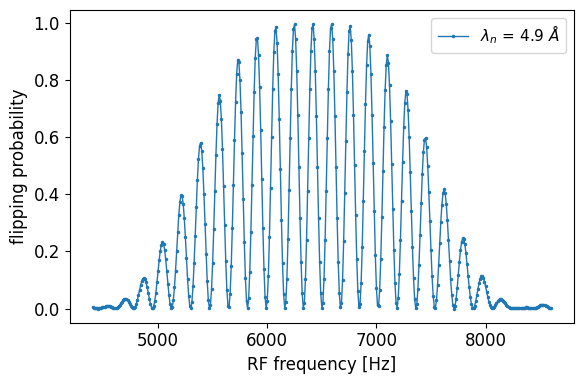

In [8]:
fig, ax = plt.subplots()
ax.plot(Omega_SF/2/pi, pFlip, '.-', ms=3, lw=1, label='$\lambda_n$ = {:.1f} $\AA$'.format(1e10*lambda_n))
ax.legend()
ax.set(xlabel='RF frequency [Hz]', ylabel='flipping probability')
fig.set(dpi=100)
fig.tight_layout()
plt.show()

### White Beam - Constant Spin-Flip Signal

In [9]:
debug = False
filename = 'data/ramseyFrequencyScan_whiteBeam_constantB1.npz'

# neutron velocity in [m/s]
V_N = np.arange(400, 2400+1, 40)

# weights for the various velocities
weights = neutronCounts_Fct(setup.l_tof/V_N)

# main magnetic field amplitude in [T]
B0 = 220e-6

# SF crossing time in [s]
# optimized for one neutron velocity
v_n = 800
tau_optimized = setup.l_sf / v_n

# SF field amplitude in [T]
# optimial value for pi/2 flip for one neutron velocity
B1 = pi/2 / gamma_n / tau_optimized

# angular frequency of the spinflipper in [rad/s]
omega_SF = gamma_n * B0

# number of steps per oscillation in B1 field / axionic field
Q = 100

In [10]:
try:
    V_N = np.load(filename)['V_N']
    Omega_SF = np.load(filename)['Omega_SF']
    pFlipMat = np.load(filename)['pFlipMat']

except:
    # RF frequency in [rad/s]
    Omega_SF = np.arange(4400, 8600+1, 20) * 2*pi
    
    pFlipMat = np.zeros((len(V_N), len(Omega_SF)))
    
    for i,v_n in enumerate(V_N):
        
        print('velocity: {:.0f} m/s'.format(v_n))
    
        # neutron wavelength [m]
        lambda_n = h / mass_n / v_n
        
        # SF crossing time in [s]
        tau = setup.l_sf / v_n
        
        # free precession time in [s]
        T = setup.l_int / v_n

        # number of steps for the full propagation
        nSF = int(Q * tau * omega_SF / 2 / pi)
        
        # simulate the propagation
        with Pool(processes=6) as pool:
            pFlip = pool.map_async(ramseyFrequencyScan, Omega_SF)
            track_job(pFlip, update_interval=1)
        pFlip = np.asarray(pFlip.get()).flatten()
        pFlipMat[i,:] = pFlip
    
        if debug:
            fig, ax = plt.subplots()
            ax.plot(Omega_SF/1e3, pFlip, '-')
            ax.set(title=r'$v_n$ = {:.0f} m/s'.format(v_n), xlabel='RF frequency [kHz]', ylabel='flipping probability')
            fig.set(dpi=80)
            fig.tight_layout()
            plt.show()
        
    np.savez(filename, V_N=V_N, Omega_SF=Omega_SF, pFlipMat=pFlipMat)

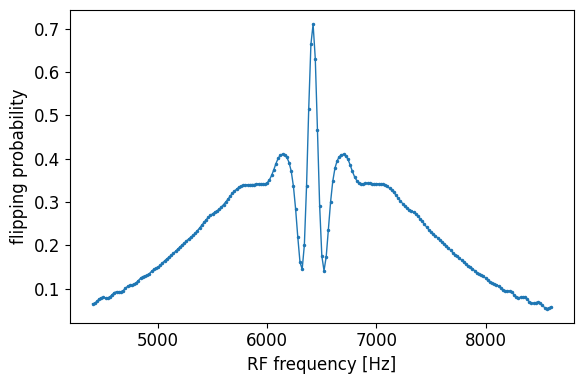

In [11]:
fig, ax = plt.subplots()
ax.plot(Omega_SF/2/pi, np.average(pFlipMat, axis=0, weights=weights), '.-', ms=3, lw=1, )
ax.set(xlabel='RF frequency [Hz]', ylabel='flipping probability')
fig.set(dpi=100)
fig.tight_layout()
plt.show()

### White Beam - Modulated Spin-Flip Signal

In [12]:
debug = False
filename = 'data/ramseyFrequencyScan_whiteBeam_modulatedB1.npz'

# neutron velocity in [m/s]
V_N = np.arange(400, 2400+1, 40)

# weights for the various velocities
weights = neutronCounts_Fct(setup.l_tof/V_N)

# main magnetic field amplitude in [T]
B0 = 220e-6

# angular frequency of the spinflipper in [rad/s]
omega_SF = gamma_n * B0

# number of steps per oscillation in B1 field / axionic field
Q = 100

In [13]:
try:
    V_N = np.load(filename)['V_N']
    Omega_SF = np.load(filename)['Omega_SF']
    pFlipMat = np.load(filename)['pFlipMat']

except:
    # RF frequency in [rad/s]
    Omega_SF = np.arange(4400, 8600+1, 20) * 2*pi
    
    pFlipMat = np.zeros((len(V_N), len(Omega_SF)))
    
    for i,v_n in enumerate(V_N):
        
        print('velocity: {:.0f} m/s'.format(v_n))
    
        # neutron wavelength [m]
        lambda_n = h / mass_n / v_n
        
        # SF crossing time in [s]
        tau = setup.l_sf / v_n
    
        # SF field amplitude in [T]
        # optimial value for pi/2 flip for each neutron velocity
        B1 = pi/2 / gamma_n / tau
        
        # free precession time in [s]
        T = setup.l_int / v_n

        # number of steps for the full propagation
        nSF = int(Q * tau * omega_SF / 2 / pi)
        
        # simulate the propagation
        with Pool(processes=4) as pool:
            pFlip = pool.map_async(ramseyFrequencyScan, Omega_SF)
            track_job(pFlip, update_interval=1)
        pFlip = np.asarray(pFlip.get()).flatten()
        pFlipMat[i,:] = pFlip
    
        if debug:
            fig, ax = plt.subplots()
            ax.plot(Omega_SF/1e3, pFlip, '-')
            ax.set(title=r'$v_n$ = {:.0f} m/s'.format(v_n), xlabel='RF frequency [kHz]', ylabel='flipping probability')
            fig.set(dpi=80)
            fig.tight_layout()
            plt.show()
        
    np.savez(filename, V_N=V_N, Omega_SF=Omega_SF, pFlipMat=pFlipMat)

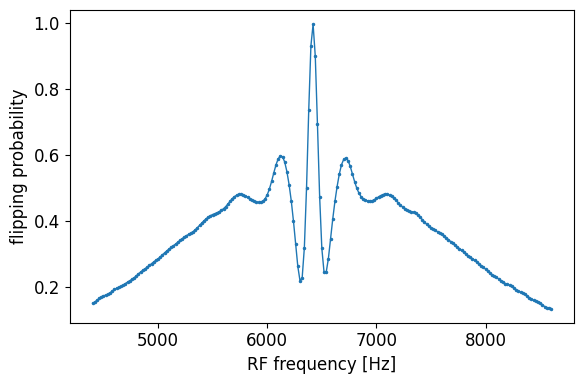

In [14]:
fig, ax = plt.subplots()
ax.plot(Omega_SF/2/pi, np.average(pFlipMat, axis=0, weights=weights), '.-', ms=3, lw=1, )
ax.set(xlabel='RF frequency [Hz]', ylabel='flipping probability')
fig.set(dpi=100)
fig.tight_layout()
plt.show()

## Axion Frequency Scan

In [15]:
def axionFrequencyScan(omega_A):
     
    # number of steps for the precession propagation
    nPrec = int(Q * T * omega_A / 2 / pi)

    # the measurement has to be scanned over one axion oscillation
    T_Start = np.linspace(0, 2/(omega_A/2/pi), 20, endpoint=False)
    T_Res = np.zeros(len(T_Start))
    for i,t_start in enumerate(T_Start):
        
        # randomize the phase of the B1 field
        nPhase = 10
        for theta_SF in np.linspace(0, pi, nPhase, endpoint=False):
            T_Res[i] += abs(spinDn.T 
                            @ matSpinflip(t_start+tau+T, t_start+tau+T+tau, B0, B1, omega_SF, theta_SF+90*pi/180, nSF) 
                            @ matAxionPrecession(t_start+tau, t_start+tau+T, B0, BA, omega_A, theta_A, nPrec) 
                            @ matSpinflip(t_start, t_start+tau, B0, B1, omega_SF, theta_SF, nSF) 
                            @ spinUp)**2
        T_Res[i] /= nPhase
    
    popt, pcov = curve_fit(sinFct, T_Start, T_Res, p0=(omega_A/2/pi, 0.5*(T_Res.max()-T_Res.min()), 0, T_Res.mean()))
    perr = np.sqrt(np.diag(pcov))

    if debug:
        fig,ax = plt.subplots()
        ax.plot(T_Start, T_Res, 'C0.')
        ax.plot(T_Start, sinFct(T_Start, *popt), 'C0--')
        plt.show()
    
    return abs(popt[1])

### Monochromatic Beam

In [16]:
filename = 'data/axionFrequencyScan_monochromaticBeam.npz'

# neutron velocity in [m/s]
v_n = 800

# neutron wavelength [m]
lambda_n = h / mass_n / v_n

# SF crossing time in [s]
tau = setup.l_sf / v_n

# free precession time in [s]
T = setup.l_ele / v_n

# main magnetic field amplitude in [T]
B0 = 220e-6

# SF field amplitude in [T]
# optimial value for pi/2 flip for one neutron velocity
B1 = pi/2 / gamma_n / tau

# axionic field amplitude in [T]
BA = 100e-9

# phase of the axionic field in [rad]
theta_A = 0

# angular frequency of the spinflipper in [rad/s]
omega_SF = gamma_n * B0

# number of steps per oscillation in B1 field / axionic field
Q = 100

# number of steps for the full propagation
nSF = int(Q * tau * omega_SF / 2 / pi)

In [17]:
try:
    Omega_A = np.load(filename)['Omega_A']
    pFlip = np.load(filename)['pFlip']

except:
    Omega_A = np.linspace(10, 610+0.01, 51, endpoint=True) * 2*pi
    
    with Pool(processes=6) as pool:
        pFlip = pool.map_async(axionFrequencyScan, Omega_A)
        track_job(pFlip, update_interval=1)
    
    pFlip = np.asarray(pFlip.get()).flatten()

    np.savez(filename, Omega_A=Omega_A, pFlip=pFlip)

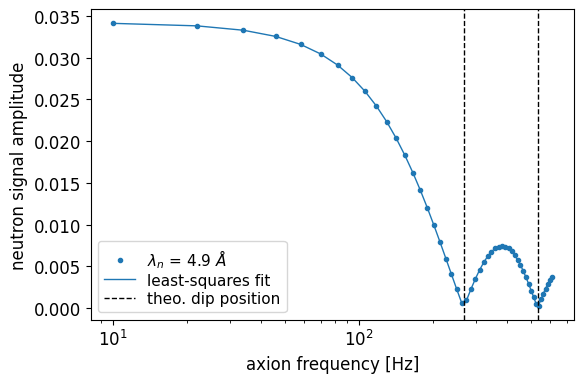

In [18]:
# fit the resonant cancelation function
popt = (1/gamma_n, setup.l_ele/v_n)
popt,_ = curve_fit(resonantCancelation, Omega_A/2/pi, pFlip, p0=popt)

fig,ax = plt.subplots()
ax.plot(Omega_A/2/pi, pFlip, 'C0.', label='$\lambda_n$ = {:.1f} $\AA$'.format(1e10*lambda_n))
ax.plot(Omega_A/2/pi, resonantCancelation(Omega_A/2/pi, *popt), 'C0-', lw=1, label='least-squares fit')
ax.axvline(v_n/setup.l_ele, c='k', ls='--', lw=1, label='theo. dip position')
ax.axvline(2*v_n/setup.l_ele, c='k', ls='--', lw=1)
ax.legend()
ax.set(xlabel='axion frequency [Hz]', ylabel='neutron signal amplitude', xscale='log')
fig.set(dpi=100)
fig.tight_layout()
plt.show()

### White Beam

In [19]:
def axionFrequencyScan_whiteBeam(omega_A):
    
    # arrival time at the detector in [s]
    T_Det = np.linspace(0, 2/(omega_A/2/pi), 20, endpoint=False)
    
    T_Res = np.zeros((len(V_N), len(T_Det)))
    
    for j,v_n in enumerate(V_N):
    
        # neutron wavelength [m]
        lambda_n = h / mass_n / v_n
        
        # SF crossing time in [s]
        tau = setup.l_sf / v_n
        
        # free precession time in [s]
        T = setup.l_ele / v_n
    
        # calculate the number of time steps required
        nPhase = 4
        
        nSF = int(Q * tau * omega_SF / 2 / pi) 
        nPrec = int(Q * T * omega_A / 2 / pi)

        for i,t_det in enumerate(T_Det):
            
            t_start = t_det - (setup.l_int + setup.l_det) / v_n

            # randomize the phase of the B1 field
            for theta_SF in np.linspace(0, pi, nPhase, endpoint=False):
                T_Res[j,i] += abs(spinDn.T 
                                  @ matSpinflip(t_start+tau+T, t_start+tau+T+tau, B0, B1, omega_SF, theta_SF+90*pi/180, nSF) 
                                  @ matAxionPrecession(t_start+tau, t_start+tau+T, B0, BA, omega_A, theta_A, nPrec) 
                                  @ matSpinflip(t_start, t_start+tau, B0, B1, omega_SF, theta_SF, nSF) 
                                  @ spinUp)**2
            T_Res[j,i] /= nPhase
    
    # average over the neutron velocities
    T_Avg = np.average(T_Res, axis=0, weights=weights)     

    if debug:
        fig, ax = plt.subplots()
        for j,v_n in enumerate(V_N):
            ax.plot(T_Det, T_Res[j,:], '.-', label=r'$v_n$ = {} m/s'.format(v_n))
        ax.plot(T_Det, T_Res, 'k.-', label=r'average')
        ax.legend(loc='upper right', bbox_to_anchor=(1.35,1), labelspacing=0.2)
        plt.show()
    
    try:
        popt, pcov = curve_fit(sinFct, T_Det, T_Res, p0=(omega_A/2/pi, 0.5*(T_Res.max()-T_Res.min()), 0, T_Res.mean()))
        perr = np.sqrt(np.diag(pcov))
        return abs(popt[1])
        
    except:
        return np.nan

In [20]:
filename = 'data/axionFrequencyScan_whiteBeam_ILL2020.npz'

# neutron velocity in [m/s]
V_N = np.arange(400, 2400+1, 40)

# weights for the various velocities
weights = neutronCounts_Fct(setup.l_tof/V_N)

# main magnetic field amplitude in [T]
B0 = 220e-6

# SF crossing time in [s]
# optimized for one neutron velocity
v_n = 800
tau_optimized = setup.l_sf / v_n

# SF field amplitude in [T]
# optimial value for pi/2 flip for one neutron velocity
B1 = pi/2 / gamma_n / tau_optimized

# axionic field amplitude in [T]
BA = 100e-9

# phase of the axionic field in [rad]
theta_A = 0

# angular frequency of the spinflipper in [rad/s]
omega_SF = gamma_n * B0

# number of steps per oscillation in B1 field / axionic field
Q = 100

In [21]:
try:
    V_N = np.load(filename)['V_N']
    Omega_A = np.load(filename)['Omega_A']
    pFlip = np.load(filename)['pFlip']

except:
    Omega_A = np.logspace(np.log10(10), np.log10(1000), 31, endpoint=True) * 2*pi
    
    with Pool(processes=6) as pool:
        pFlip = pool.map_async(axionFrequencyScan_whiteBeam, Omega_A)
        track_job(pFlip, update_interval=2)
    
    pFlip = np.asarray(pFlip.get()).flatten()

    np.savez(filename, V_N=V_N, Omega_A=Omega_A, pFlip=pFlip)

3 dB cut-off frequency: 81(2) Hz


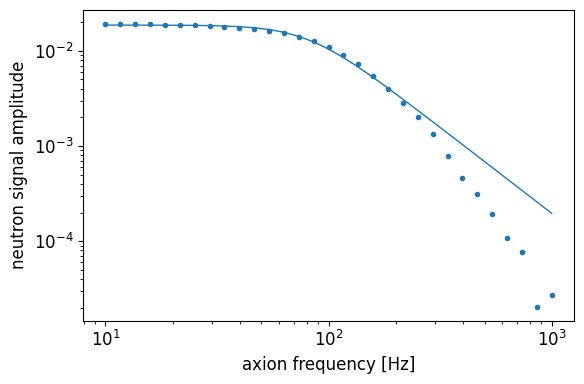

In [28]:
# fit a higher-order low-pass filter function into the simulated data
popt, pcov = curve_fit(butterworthFct, Omega_A, pFlip, p0=(pFlip.max(), 100, 1))
perr = np.sqrt(np.diag(pcov))
print('3 dB cut-off frequency: {:.0f}({:.0f}) Hz'.format(popt[1]/2/pi, perr[1]/2/pi))

# plot the data and the fit
fig,ax = plt.subplots()
ax.plot(Omega_A/2/pi, pFlip, 'C0.')
plt.plot(Omega_A/2/pi, butterworthFct(Omega_A, *popt), 'C0-', lw=1)
ax.set(xlabel='axion frequency [Hz]', ylabel='neutron signal amplitude', xscale='log', yscale='log')
fig.set(dpi=100)
fig.tight_layout()
plt.show()